## Контрастное обучение с SimCLR
[SimCLR](https://arxiv.org/abs/2002.05709) (Simple Contrastive Learning Representation): self-supervised модель, которая используется для получения осмысленных представлений изображений

<!-- <img src="../images/simclr_im1.png" alt="drawing" width="600"/> -->



## Contrastive learning framework

<!-- <img src="../images/simclr_im2.png" alt="drawing" width="700"/> -->

## Обучение на CIFAR-10
Обучим модель извлечения признаков изображений на наборе данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Для обучения эмбеддингов будем использовать контрастную функцию потерь.

Из набора данных выбираем $N$ изображений и для каждого из них получаем 2 избражения, используя 2 случаных преобразования (кроп, изменение цвета) исходного изображения. Пару изображений, полученных от одного изображения будем называть положительной парой, иначе отрицательной. Теперь мы имеем $2N$ изображений

Для каждой пары положительной пары $(i,j)$ определим функцию потерь, которая вынуждает модель выдавать близкие по метрике эмбеддинги для положительных пар, и далёкие для отрицательных.

$$
l_{i,j} = -\log\frac{\exp(\text{sim}(\textbf{z}_i, \textbf{z}_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(\textbf{z}_i,\textbf{z}_k)/\tau)}
$$

$$
\text{sim}(\textbf{u}, \textbf{v}) = \textbf{u}^T\textbf{v}/\left\lVert\textbf{u}\right\rVert \left\lVert\textbf{v}\right\rVert
$$

Итоговая функция потерь:

$$
\mathcal{L} = \frac{1}{2N}\sum_{k=1}^N[l(2k-1,2k) + l(2k, 2k - 1)]
$$


In [25]:
import torchvision
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch.nn.functional as F
from torch import nn
from utils import AverageMeter, ProgressMeter, accuracy
import time
from torchvision import transforms

%load_ext autoreload
%autoreload 2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Задание модели

В качестве бекбона будем использовать модификацию [ResNet-50](https://arxiv.org/abs/1512.03385)

Так как разрешение изображений в наборе данных CIFAR-10, меньше чем в на наборе данных [ImageNet](https://www.image-net.org/), мы заменим первый свёрточный слой с ядром $(7\times 7)$ и страйдом $2$, на свёрточный слой с ядром размера $(3\times3)$ и страйдом $1$  
Также мы удалим первый maxpolling слой

In [2]:
resnet50 = torchvision.models.resnet50(pretrained=False).to(device)

new_modules = [
    nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
] + list(resnet50.children())[4:-1]
resnet50_cifar = torch.nn.Sequential(*new_modules).to(device)

# summary(resnet50_cifar, (3, 32, 32))

In [34]:
class SimCLR(nn.Module):
    def __init__(
        self,
        base_encoder: torch.nn.Module,
        projection_dim=128,
        temp=0.5,
    ) -> None:
        super().__init__()
        self.projection_dim = projection_dim
        self.temp = temp

        # define base_encoder x -> h
        self.base_encoder = base_encoder
        self.latent_dim = 2048

        # define projection head h -> z

        self.projection_head = nn.Sequential(
            nn.Linear(self.latent_dim, self.projection_dim, bias=False),
            nn.BatchNorm1d(self.projection_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_dim, self.projection_dim, bias=False),
            nn.BatchNorm1d(self.projection_dim, affine=False),
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """
        Takes batch of augmented images, and computes contrastive loss
        """

        batch_size = images[0].shape[0]

        first_view, second_view = images

        # compute embeddings
        first_h = torch.squeeze(self.base_encoder(first_view))
        second_h = torch.squeeze(self.base_encoder(second_view))

        first_z = self.projection_head(first_h)
        second_z = self.projection_head(second_h)

        # normalize
        first_z, second_z = F.normalize(first_z), F.normalize(second_z)

        # compute similarities

        view_cat = torch.cat([first_z, second_z], dim=0)  # 2N x d
        s = view_cat @ view_cat.T  # 2N x 2N

        s = s / self.temp

        # Mask out same-sample terms

        s[torch.arange(2 * batch_size), torch.arange(2 * batch_size)] = -float("inf")

        # compute loss
        targets = torch.cat(
            (
                torch.arange(batch_size, 2 * batch_size),
                torch.arange(0, batch_size),
            ),
            dim=0,
        )
        targets = targets.to(s.get_device()).long()

        loss = F.cross_entropy(s, targets, reduction="sum")

        loss = loss / (2 * batch_size)

        return loss, first_h

### 1) Загрузка данных

In [4]:
def get_transform(train, sim_clr_trans=True):
    if train:
        if sim_clr_trans:
            transform = transforms.Compose(
                [
                    transforms.RandomResizedCrop(32),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomApply(
                        [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8
                    ),
                    transforms.RandomGrayscale(p=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
                    ),
                ]
            )
        else:
            transform = transforms.Compose(
                [
                    transforms.Resize((32, 32)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
                    ),
                ]
            )
    else:
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
                ),
            ]
        )
    return transform


class SimCLRDataTransform(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        xi = self.transform(sample)
        xj = self.transform(sample)
        return xi, xj

In [5]:
DATA_PATH = "../data"
OUT_PATH = Path("../outputs/cifar_10_ssl_v2")
OUT_PATH.mkdir(exist_ok=True)
BATCH_SIZE = 128
NUM_WORKERS = 12

N_EPOCH = 1000
LR = 1.0
MOMENTUM = 0.9
WD = 1e-6


train_dset = torchvision.datasets.CIFAR10(
    DATA_PATH,
    train=True,
    transform=SimCLRDataTransform(get_transform(train=True)),
    download=True,
)
test_dset = torchvision.datasets.CIFAR10(
    DATA_PATH,
    train=False,
    transform=SimCLRDataTransform(get_transform(train=False)),
    download=True,
)

train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

val_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

Files already downloaded and verified
Files already downloaded and verified


### Обучение
Всместе с Self-supervised моделью будем обучать линейную модель, для подсчёта точности предсказаний линейной модели

In [6]:
from lars import LARS


# self-supervised model
model = SimCLR(base_encoder=resnet50_cifar).to(device)
optimizer = LARS(
    model.parameters(),
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=WD,
)

# linear model
linear_classifier = nn.Sequential(nn.Linear(model.latent_dim, 10)).to(device)
optimizer_linear = torch.optim.SGD(
    linear_classifier.parameters(),
    lr=LR,
    momentum=MOMENTUM,
    nesterov=True,
)

# define schdulers
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, N_EPOCH, 0, -1)
scheduler_linear = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_linear, N_EPOCH, 0, -1
)

In [7]:
def train(
    train_loader, model, linear_classifier, optimizer, optimizer_linear, epoch, device
):
    batch_time = AverageMeter("Time", ":6.3f")
    data_time = AverageMeter("Data", ":6.3f")
    top1 = AverageMeter("LinearAcc@1", ":6.2f")
    top5 = AverageMeter("LinearAcc@5", ":6.2f")
    avg_meters = {k: AverageMeter(k, fmt) for k, fmt in zip(["Loss"], [":.4e"])}
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, top1, top5] + list(avg_meters.values()),
        prefix="Epoch: [{}]".format(epoch),
    )

    # switch to train mode
    model.train()
    linear_classifier.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        batch_size = images[0].shape[0]

        images = [x.to(device) for x in images]
        target = target.to(device)

        loss, hs = model(images)
        hs = hs.detach()

        avg_meters["Loss"].update(loss.item(), batch_size)

        # compute gradient and optimizer step for ssl task
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute gradient and optimizer step for classifier
        logits = linear_classifier(hs)
        loss_linear = F.cross_entropy(logits, target)

        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1.update(acc1[0], batch_size)
        top5.update(acc5[0], batch_size)

        optimizer_linear.zero_grad()
        loss_linear.backward()
        optimizer_linear.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            progress.display(i)

In [8]:
def validate(val_loader, model, linear_classifier, device):
    batch_time = AverageMeter("Time", ":6.3f")
    data_time = AverageMeter("Data", ":6.3f")
    top1 = AverageMeter("LinearAcc@1", ":6.2f")
    top5 = AverageMeter("LinearAcc@5", ":6.2f")
    avg_meters = {k: AverageMeter(k, fmt) for k, fmt in zip(["Loss"], [":.4e"])}
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, data_time, top1, top5] + list(avg_meters.values()),
        prefix="Test: ",
    )

    # switch to evaluate mode
    model.eval()
    linear_classifier.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            # compute and measure loss
            batch_size = images[0].shape[0]

            images = [x.to(device) for x in images]
            target = target.to(device)

            loss, hs = model(images)

            avg_meters["Loss"].update(loss.item(), batch_size)

            logits = linear_classifier(hs)
            acc1, acc5 = accuracy(logits, target, topk=(1, 5))
            top1.update(acc1[0], batch_size)
            top5.update(acc5[0], batch_size)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 10 == 0:
                progress.display(i)

    data = torch.FloatTensor(
        [avg_meters["Loss"].avg, top1.avg, top5.avg]
        + [v.avg for v in avg_meters.values()]
    )

    print_str = f" * LinearAcc@1 {data[1]:.3f} LinearAcc@5 {data[2]:.3f}"
    for i, (k, v) in enumerate(avg_meters.items()):
        print_str += f" {k} {data[i+3]:.3f}"
    print(print_str)

    return data[0], data[1]

In [28]:
import shutil


def save_checkpoint(state, is_best, out_path, filename="checkpoint.pth.tar"):
    filename = out_path / filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, out_path / "model_best.pth.tar")

In [10]:
# best_loss = float("inf")
# best_acc = 0.0
# model.train()
# for epoch in range(N_EPOCH):
#     # train
#     train(
#             train_loader,
#             model,
#             linear_classifier,
#             optimizer,
#             optimizer_linear,
#             epoch,
#             device
#         )

#     # validate
#     val_loss, val_acc = validate(val_loader, model, linear_classifier, device)

#     # update scheduler
#     scheduler.step()
#     scheduler_linear.step()

#     # save checkpoint
#     is_best = val_loss < best_loss
#     best_loss = min(val_loss, best_loss)
#     save_checkpoint(
#         {
#             "epoch": epoch + 1,
#             "state_dict": model.state_dict(),
#             "optimizer": optimizer.state_dict(),
#             "scheduler": scheduler.state_dict(),
#             "state_dict_linear": linear_classifier.state_dict(),
#             "optimizer_linear": optimizer_linear.state_dict(),
#             "schedular_linear": scheduler_linear.state_dict(),
#             "best_loss": best_loss,
#             "best_acc": val_acc,
#         },
#         is_best,
#          out_path=OUT_PATH,
#     )

In [32]:
def load_model(out_path):
    ckpt_pth = out_path / "model_best.pth.tar"
    ckpt = torch.load(ckpt_pth, map_location="cpu")
    
    resnet50 = torchvision.models.resnet50(pretrained=False).to(device)
    new_modules = [
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
    ] + list(resnet50.children())[4:-1]
    resnet50_cifar = torch.nn.Sequential(*new_modules).to(device)

    model = SimCLR(base_encoder=resnet50_cifar).to(device)
    model.load_state_dict(ckpt["state_dict"])

    model.eval()

    linear_classifier = nn.Sequential(nn.Linear(model.latent_dim, 10)).to(device)
    linear_classifier.load_state_dict(ckpt["state_dict_linear"])

    linear_classifier.cuda()
    linear_classifier.eval()

    return model, linear_classifier

In [ ]:
# from utils import evaluate_classifier

# model, linear_classifier = load_model(Path("../outputs/cifar_10_ssl"))
# test_acc1, test_acc5 = evaluate_classifier(model, linear_classifier, val_loader, device)
# print("Test Set")
# print(f"Top 1 Accuracy: {test_acc1}, Top 5 Accuracy: {test_acc5}\n")

### Обучение с небольшим числом лейблов

In [15]:
def train_cifar10_classifier(
    train_loader, model, optimizer, epoch, device, finetune_extractor
):
    batch_time = AverageMeter("Time", ":6.3f")
    data_time = AverageMeter("Data", ":6.3f")
    top1 = AverageMeter("LinearAcc@1", ":6.2f")
    top5 = AverageMeter("LinearAcc@5", ":6.2f")
    avg_meters = {k: AverageMeter(k, fmt) for k, fmt in zip(["Loss"], [":.4e"])}
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, top1, top5] + list(avg_meters.values()),
        prefix="Epoch: [{}]".format(epoch),
    )

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        batch_size = images.shape[0]

        images = images.to(device)
        target = target.to(device)


        # compute gradient and optimizer step for classifier
        logits = model(images)
        loss = F.cross_entropy(logits, target)

        avg_meters["Loss"].update(loss.item(), batch_size)

        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1.update(acc1[0], batch_size)
        top5.update(acc5[0], batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            progress.display(i)

In [16]:
def validate_cifar10_classifier(val_loader, model, device):
    batch_time = AverageMeter("Time", ":6.3f")
    data_time = AverageMeter("Data", ":6.3f")
    top1 = AverageMeter("LinearAcc@1", ":6.2f")
    top5 = AverageMeter("LinearAcc@5", ":6.2f")
    avg_meters = {k: AverageMeter(k, fmt) for k, fmt in zip(["Loss"], [":.4e"])}
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, data_time, top1, top5] + list(avg_meters.values()),
        prefix="Test: ",
    )

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            # compute and measure loss
            batch_size = images.shape[0]

            images = images.to(device)
            target = target.to(device)


            logits = model(images)
            acc1, acc5 = accuracy(logits, target, topk=(1, 5))
            top1.update(acc1[0], batch_size)
            top5.update(acc5[0], batch_size)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 10 == 0:
                progress.display(i)

    data = torch.FloatTensor(
        [avg_meters["Loss"].avg, top1.avg, top5.avg]
        + [v.avg for v in avg_meters.values()]
    )

    print_str = f" * LinearAcc@1 {data[1]:.3f} LinearAcc@5 {data[2]:.3f}"
    print(print_str)

    return data[0], data[1]

In [42]:
def train_linear(
    model, run_name, train_loader, val_loader, n_epoch, finetune_extractor
):
    out_path = Path("../outputs") / run_name
    out_path.mkdir(exist_ok=True, parents=True)
    best_loss = float("inf")
    best_acc = 0.0

    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    val_acc_history = []
    for epoch in range(n_epoch):
        #train
        train_cifar10_classifier(
            train_loader,
            model,
            optimizer,
            epoch,
            device,
            finetune_extractor,
        )

        # validate
        val_loss, val_acc = validate_cifar10_classifier(
            val_loader, model, device
        )
        val_acc_history.append(val_acc)
        # update scheduler
        # scheduler.step()

        # save checkpoint
        is_best = val_acc > best_acc
        best_acc = min(val_acc, best_acc)
        save_checkpoint(
            {
                "epoch": epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "state_dict_linear": linear_classifier.state_dict(),
                "best_loss": best_loss,
                "best_acc": val_acc,
                "val_acc_history": val_acc_history
            },
            is_best,
            out_path=out_path,
        )

### Определим модель для обучения на cifar10

In [16]:
class Classifier(nn.Module):
    def __init__(self, base_encoder: torch.nn.Module = None, train_base_encoder = True) -> None:
        super().__init__()
        if base_encoder is None:
            resnet50 = torchvision.models.resnet50(pretrained=False).to(device)
            new_modules = [
                nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
            ] + list(resnet50.children())[4:-1]
            resnet50_cifar = torch.nn.Sequential(*new_modules).to(device)

            base_encoder = resnet50_cifar
        
        self.base_encoder = base_encoder

        if train_base_encoder is False:
            for param in self.base_encoder.parameters():
                param.requires_grad = False
                
        self.linear_head = nn.Sequential(nn.Linear(2048, 10))
    
    def forward(self, images):
        hi = torch.squeeze(self.base_encoder(images))
        return self.linear_head(hi)
        

In [17]:
BATCH_SIZE = 64
train_dset = torchvision.datasets.CIFAR10(
    DATA_PATH,
    train=True,
    transform=get_transform(train=True, sim_clr_trans=False),
    download=True,
)
test_dset = torchvision.datasets.CIFAR10(
    DATA_PATH,
    train=False,
    transform=get_transform(train=False),
    download=True,
)

train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

val_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
import numpy as np
# class_to_instances = {class_id: [] for class_id in range(10)}

# for i in range(len(train_dset)):
#     class_to_instances[train_dset[i][1]].append(i)


# # Save
# np.save('class_to_instances.npy', class_to_instances) 

# Load
class_to_instances = np.load('class_to_instances.npy',allow_pickle='TRUE').item()

In [19]:
def take_portion_of_train_set(train_dset, fraction, class_to_instances, batch_size):
    idx = []
    for class_id, instances in class_to_instances.items():
        idx += instances[: int(len(instances) * fraction)]

    train_dset_fraction = torch.utils.data.Subset(train_dset, idx)
    
    train_loader = torch.utils.data.DataLoader(
        train_dset_fraction,
        batch_size=batch_size,
        num_workers=12,
        drop_last=False,
        shuffle=True,
    )
    return train_loader

## Обучим 2 модели с различными количествами лейблов

In [21]:
model_ssl, linear_classifier = load_model(Path("../outputs/cifar_10_ssl"))

In [22]:
N_EPOCH = 20

for base_encoder in [None, model_ssl.base_encoder]:
    for frac in [0.01, 0.1, 0.5, 1]:
        model = Classifier(base_encoder).to(device)
        if base_encoder is None:
            model_name = 'resnet_from_scratch'
        else:
            model_name = 'cifar_10_ssl_finetune'
            
        run_name = f"{model_name}/full_finetune_on_{frac}_labeles"
        
        train_loader = take_portion_of_train_set(train_dset, frac, class_to_instances, BATCH_SIZE)
        train_linear(
            model = model,
            run_name=run_name,
            train_loader=train_loader,
            val_loader=val_loader,
            n_epoch=N_EPOCH,
            finetune_extractor=True,
        )

Epoch: [0][0/8]	Time  1.277 ( 1.277)	Data  0.736 ( 0.736)	LinearAcc@1  15.62 ( 15.62)	LinearAcc@5  54.69 ( 54.69)	Loss 2.3473e+00 (2.3473e+00)
Test: [  0/156]	Time  0.750 ( 0.750)	Data  0.000 ( 0.000)	LinearAcc@1   6.25 (  6.25)	LinearAcc@5  50.00 ( 50.00)	Loss 0.0000e+00 (0.0000e+00)
Test: [ 10/156]	Time  0.039 ( 0.103)	Data  0.000 ( 0.000)	LinearAcc@1   7.81 (  7.81)	LinearAcc@5  54.69 ( 50.43)	Loss 0.0000e+00 (0.0000e+00)
Test: [ 20/156]	Time  0.040 ( 0.073)	Data  0.000 ( 0.000)	LinearAcc@1  14.06 (  8.63)	LinearAcc@5  45.31 ( 51.26)	Loss 0.0000e+00 (0.0000e+00)
Test: [ 30/156]	Time  0.039 ( 0.062)	Data  0.000 ( 0.000)	LinearAcc@1   9.38 (  9.07)	LinearAcc@5  56.25 ( 51.16)	Loss 0.0000e+00 (0.0000e+00)
Test: [ 40/156]	Time  0.039 ( 0.056)	Data  0.000 ( 0.000)	LinearAcc@1  17.19 (  9.18)	LinearAcc@5  59.38 ( 51.33)	Loss 0.0000e+00 (0.0000e+00)
Test: [ 50/156]	Time  0.039 ( 0.053)	Data  0.000 ( 0.000)	LinearAcc@1  17.19 (  9.41)	LinearAcc@5  45.31 ( 50.67)	Loss 0.0000e+00 (0.0000e+00)

### Построим графики обучения

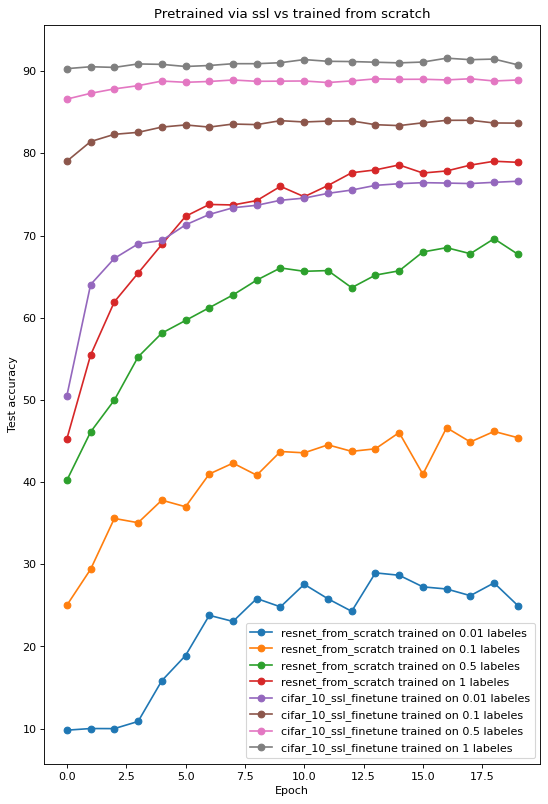

In [35]:
plt.figure(figsize=(8, 12), dpi=80)
for model_name in ['resnet_from_scratch', 'cifar_10_ssl_finetune']:
    for frac in [0.01, 0.1, 0.5, 1]:
        run_name = f"{model_name}/full_finetune_on_{frac}_labeles"
        ckpt_pth = Path("../outputs") / run_name / 'checkpoint.pth.tar'
        ckpt = torch.load(ckpt_pth, map_location="cpu")
        
        ys = [float(x) for x in ckpt['val_acc_history']]
        xs = np.arange(len(ys))

        plt.plot(xs, ys, 'o-', label=f'{model_name} trained on {frac} labeles')


plt.xlabel('Epoch')
plt.ylabel('Test accuracy')
plt.legend()
plt.title('Pretrained via ssl vs trained from scratch')
plt.show()

In [27]:
ckpt = torch.load('/app/s12_self-supervised/outputs/cifar_10_ssl_finetune/full_finetune_on_1_labeles/checkpoint.pth.tar', map_location="cpu")

# Дообучение на caltech101

## 1. Подготовка данных

In [38]:
DATA_PATH = "../data"  # PATH TO THE DATASET

transformer = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # scaling images to fixed size
        transforms.ToTensor(),  # converting to tensors
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0) if x.shape[0] == 1 else x
        ),  # treat gray images
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # normalize image data per-channel
    ]
)

caltech101 = torchvision.datasets.Caltech101(
    root=DATA_PATH, download=True, transform=transformer
)
torch.manual_seed(0)
train_dset, test_dset = torch.utils.data.random_split(caltech101, [7000, 1677])

val_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

BATCH_SIZE = 32
NUM_WORKERS = 12

Files already downloaded and verified


In [39]:
# class_to_instances_caltech = {class_id: [] for class_id in range(101)}

# for i in range(len(train_dset)):
#     class_to_instances_caltech[train_dset[i][1]].append(i)


# np.save('class_to_instances_caltech.npy', class_to_instances_caltech) 


class_to_instances_caltech = np.load('class_to_instances_caltech.npy',allow_pickle='TRUE').item()

## 2. Задание модели

In [40]:
from resnet import get_resnet

class ClassifierCaltech(nn.Module):
    def __init__(self, weights_path = None) -> None:
        super().__init__()
        model, _ = get_resnet(50, 1, 0)
        if weights_path is not None:
            model.load_state_dict(torch.load(weights_path)['resnet'])
        
        self.base_encoder = model
                        
        self.linear_head = nn.Sequential(nn.Linear(2048, 101))
    
    def forward(self, images):
        hi = torch.squeeze(self.base_encoder(images))
        return self.linear_head(hi)
        

## 3. Обучение классификатора

In [45]:
N_EPOCH = 20

for weights_path in [None, '../data/r50_1x_sk0.pth']:
    for frac in [0.1, 0.3, 0.5, 1]:
        model = ClassifierCaltech(weights_path).to(device)
        if weights_path is None:
            model_name = 'caltech_resnet_from_scratch'
        else:
            model_name = 'caltech_resnet_ssl_finetune'
        run_name = f"{model_name}/full_finetune_on_{frac}_labeles"
        
        train_loader = take_portion_of_train_set(train_dset, frac, class_to_instances_caltech, BATCH_SIZE)
        train_linear(
            model = model,
            run_name=run_name,
            train_loader=train_loader,
            val_loader=val_loader,
            n_epoch=N_EPOCH,
            finetune_extractor=True,
        )

Epoch: [0][ 0/21]	Time  0.818 ( 0.818)	Data  0.624 ( 0.624)	LinearAcc@1   0.00 (  0.00)	LinearAcc@5   6.25 (  6.25)	Loss 4.8817e+00 (4.8817e+00)
Epoch: [0][10/21]	Time  0.187 ( 0.245)	Data  0.003 ( 0.061)	LinearAcc@1  12.50 ( 11.93)	LinearAcc@5  21.88 ( 25.00)	Loss 4.5413e+00 (4.5424e+00)
Epoch: [0][20/21]	Time  0.113 ( 0.213)	Data  0.003 ( 0.034)	LinearAcc@1  29.41 ( 13.85)	LinearAcc@5  35.29 ( 29.53)	Loss 4.0490e+00 (4.3905e+00)
Test: [ 0/52]	Time  0.662 ( 0.662)	Data  0.000 ( 0.000)	LinearAcc@1  12.50 ( 12.50)	LinearAcc@5  34.38 ( 34.38)	Loss 0.0000e+00 (0.0000e+00)
Test: [10/52]	Time  0.053 ( 0.108)	Data  0.000 ( 0.000)	LinearAcc@1   9.38 (  5.68)	LinearAcc@5  28.12 ( 25.57)	Loss 0.0000e+00 (0.0000e+00)
Test: [20/52]	Time  0.052 ( 0.082)	Data  0.000 ( 0.000)	LinearAcc@1   0.00 (  5.21)	LinearAcc@5  25.00 ( 24.26)	Loss 0.0000e+00 (0.0000e+00)
Test: [30/52]	Time  0.053 ( 0.073)	Data  0.000 ( 0.000)	LinearAcc@1   9.38 (  5.34)	LinearAcc@5  34.38 ( 24.80)	Loss 0.0000e+00 (0.0000e+00)
T

## Графики

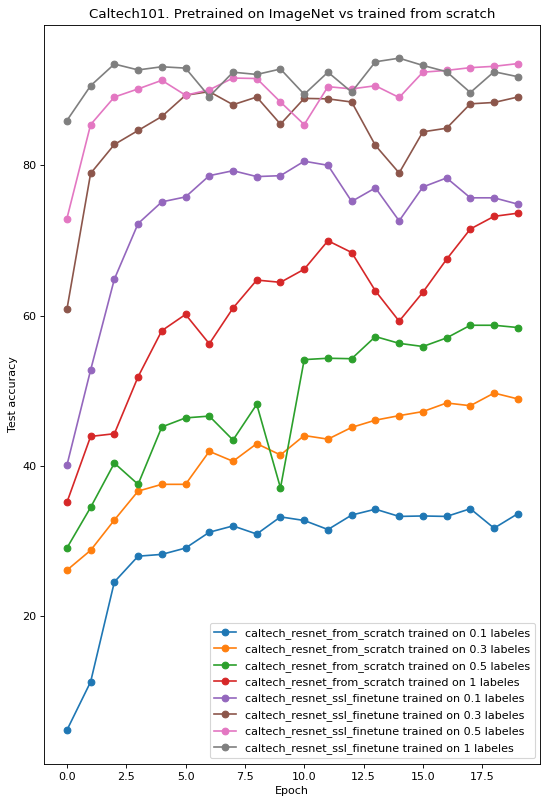

In [46]:
plt.figure(figsize=(8, 12), dpi=80)
for model_name in ['caltech_resnet_from_scratch', 'caltech_resnet_ssl_finetune']:
    for frac in [0.1, 0.3, 0.5, 1]:
        run_name = f"{model_name}/full_finetune_on_{frac}_labeles"
        ckpt_pth = Path("../outputs") / run_name / 'checkpoint.pth.tar'
        ckpt = torch.load(ckpt_pth, map_location="cpu")
        
        ys = [float(x) for x in ckpt['val_acc_history']]
        xs = np.arange(len(ys))

        plt.plot(xs, ys, 'o-', label=f'{model_name} trained on {frac} labeles')


plt.xlabel('Epoch')
plt.ylabel('Test accuracy')
plt.legend()
plt.title('Caltech101. Pretrained on ImageNet vs trained from scratch')
plt.show()

## Предобучение на caltech101 предобученной на ImageNet модели

In [ ]:
DATA_PATH = "../data"
OUT_PATH = Path("../outputs/caltech_101_ssl")
OUT_PATH.mkdir(exist_ok=True)
BATCH_SIZE = 64
NUM_WORKERS = 12

N_EPOCH = 1000
LR = 1.0
MOMENTUM = 0.9
WD = 1e-6

In [ ]:
# https://github.com/sthalles/SimCLR/blob/master/data_aug/gaussian_blur.py
import cv2
class GaussianBlur(object):
    # Implements Gaussian blur as described in the SimCLR paper
    def __init__(self, kernel_size, min=0.1, max=2.0):
        self.min = min
        self.max = max
        # kernel size is set to be 10% of the image height/width
        self.kernel_size = kernel_size

    def __call__(self, sample):
        sample = np.array(sample)

        # blur the image with a 50% chance
        prob = np.random.random_sample()

        if prob < 0.5:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            sample = cv2.GaussianBlur(
                sample, (self.kernel_size, self.kernel_size), sigma
            )

        return sample

In [ ]:
transform_train = transforms.Compose(
        [
            transforms.RandomResizedCrop((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply(
                [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(kernel_size=11),
            transforms.ToTensor(),
            transforms.Normalize(
                (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
            ),
        ]
    )

transform_test = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # scaling images to fixed size
        transforms.ToTensor(),  # converting to tensors
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0) if x.shape[0] == 1 else x
        ),  # treat gray images
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # normalize image data per-channel
    ]
)

caltech101 = torchvision.datasets.Caltech101(
    root=DATA_PATH, download=True
)

# make train test split
torch.manual_seed(0)
train_dset, test_dset = torch.utils.data.random_split(caltech101, [7000, 1677])

train_dset.transform = SimCLRDataTransform(transform_train)
test_dset.transform = SimCLRDataTransform(transform_test)


train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

val_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)


In [ ]:
from lars import LARS

# load pretrained on ImageNet ssl model

resnet50_imagenet, _ = get_resnet(50, 1, 0)

resnet50_imagenet.load_state_dict(torch.load('../data/r50_1x_sk0.pth')['resnet'])

# self-supervised model
model = SimCLR(base_encoder=resnet50_imagenet).to(device)
optimizer = LARS(
    model.parameters(),
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=WD,
)

# linear model
linear_classifier = nn.Sequential(nn.Linear(model.latent_dim, 10)).to(device)
optimizer_linear = torch.optim.SGD(
    linear_classifier.parameters(),
    lr=LR,
    momentum=MOMENTUM,
    nesterov=True,
)

# define schdulers
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, N_EPOCH, 0, -1)
scheduler_linear = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_linear, N_EPOCH, 0, -1
)

In [ ]:
best_loss = float("inf")
best_acc = 0.0
model.train()
for epoch in range(N_EPOCH):
    # train
    train(
            train_loader,
            model,
            linear_classifier,
            optimizer,
            optimizer_linear,
            epoch,
            device
        )

    # validate
    val_loss, val_acc = validate(val_loader, model, linear_classifier, device)

    # update scheduler
    scheduler.step()
    scheduler_linear.step()

    # save checkpoint
    is_best = val_loss < best_loss
    best_loss = min(val_loss, best_loss)
    save_checkpoint(
        {
            "epoch": epoch + 1,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "state_dict_linear": linear_classifier.state_dict(),
            "optimizer_linear": optimizer_linear.state_dict(),
            "schedular_linear": scheduler_linear.state_dict(),
            "best_loss": best_loss,
            "best_acc": val_acc,
        },
        is_best,
         out_path=OUT_PATH,
    )

## Дообучение с разным числом лейблов